<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 100px">

# Capstone Project: Classifying Logistics Research Papers
## Part 3 : EDA

---

 [Part 1: Get Text](01.Get_Text.ipynb) | [Part 2: Add Label](02.Add_Label.ipynb) | **Part 3: EDA** | [Part 4: Gridsearch Classification](04.Gridsearch_Classification.ipynb) | [Part 5: Neural Network Classification](05.NeuralNet_Classification.ipynb) | [Part 6: Model Evaluation](06.Model_Evaluation.ipynb) | [Part 7: Final Model](07.Final_Model.ipynb) 

---

### Introduction
This notebook provides insights and analyzes data behaviors from research papers as follows:

- **Tokenizer Comparison**: Compare tokenization results from three engines: **Newmm**, **Deepcut**, and **WangchanBERTa (pretrained)**.
- **Content length** : Analyze the text length from abstracts and full papers.
- **Word count** : Examine the word count from abstracts and full papers to aid in selecting features for model tuning in the next steps.
- **Category Distribution** : Display the number of research papers in each category.
- **Top words** : Identify the most frequently occurring words in the research papers.
- **Important words by category** : Highlight the key words for each category and compare their significance across other categories.

### Import Library

In [50]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from wordcloud import WordCloud
import re

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words, thai_stopwords
from pythainlp.util import dict_trie

import deepcut
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [51]:
df = pd.read_csv('../data/reseacrh_label_added.csv')
df.head()

Unnamed: 0                                            project  \
0           0  การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...   
1           1  การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...   
2           2  การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...   
3           3  แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...   
4           4      การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม   

                                            abstract  \
0  ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...   
1  งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...   
2  ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...   
3  การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...   
4  จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...   

                                             content  \
0  การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...   
1  การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...   
2  การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...   
3  แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...   
4  การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม ...   

                          category  category_id  
0                    Import-Export            5  
1         Procurement and Sourcing            0  
2  Distribution and Transportation            3  
3         Procurement and Sourcing            0  
4                  Demand Planning            4

In [53]:
df.shape

(340, 6)

In [54]:
# remove special charecters keep only and replace NaN or non-string values with empty string before applying the regex
df['content'] = df['content'].apply(lambda x: re.sub(r'[^A-Za-z0-9\sก-ฮะ-์]', '', str(x)) if isinstance(x, str) else '')

---

### Word Tokenization

in this step, I will explore three engines to tokenize text in a list of strings and select the engine that performs the best for future processing.

**Options for engine**
1. **newmm** (default) is a dictionary-based approach that performs maximum matching, constrained by Thai Character Cluster (TCC) boundaries with improved TCC rules.

2. [**DeepCut**](https://github.com/rkcosmos/deepcut)
is a learning-based tokenization engine that leverages deep learning to segment Thai text.
3. [**WangchanBERTa**](https://huggingface.co/airesearch/wangchanberta-base-att-spm-uncased)
is a pre-trained transformer-based language model designed specifically for Thai text. It builds upon the BERT architecture and incorporates innovations and optimizations tailored for the Thai language, making it a powerful tool for various Natural Language Processing (NLP) tasks in Thai.

In [55]:
# Checking tokenizer performance using the first 5 abstracts as sample texts
sample = ' '.join(df['abstract'][:5].to_list())

In [56]:
# Add custom word to keep from 5 sample abstract
added_words = ['การนำเข้า', 'ฐานนิยม', 'คราฟท์', 'แนวทาง', 'ผู้ส่งมอบ', 'โซ่อุปทาน', 'ปัจจัยรอง', 
               'การส่งมอบ', 'รถขนส่ง', 'นำไปใช้งาน', 'อย่างถูกต้อง', 'การขับรถ', 'ที่เกี่ยวข้อง', 
               'ในการปฏิบัติงาน', 'พนักงานขับรถ', 'สิ่งสำคัญ', 'ขั้นตอน', 'ที่ชัดเจน', 'การไหล', 'ยอดขาย', 
              'การจัดทำ', 'คราฟท์เบียร์', 'ฝึกสหกิจ', 'อย่างก้าวกระโดด','การจัดซื้อจัดหา','กระบวนการ',
               'แบบประเมิน','เก็บข้อมูล','อย่างชัดเจน','การดำเนินการ','การส่งเสริม','ถังดับเพลิง','แนวทาง', 'โลจิสติคส์']

# Merge custom words with Thai dictionary words
custom_words = set(thai_words()).union(added_words)
custom_trie = dict_trie(custom_words)  # Create a trie from the custom dictionary

In [57]:
newmm_tokenize = word_tokenize(sample,custom_dict = custom_trie, engine="newmm")

In [58]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

deepcut_tokenize  = word_tokenize(sample,custom_dict = custom_trie, engine="deepcut")

226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


In [59]:
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
model = AutoModelForMaskedLM.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

wangchan_tokenize = tokenizer.tokenize(sample)

In [60]:
# Compare each tokenizer against others
all_tokenized = {
    "newmm": set(newmm_tokenize),
    "deepcut": set(deepcut_tokenize),
    "wangchan": set(wangchan_tokenize),
}

print('Words in newmm but not tokenized in other engines:')
print(', '.join(all_tokenized["newmm"] - (all_tokenized["deepcut"] | all_tokenized["wangchan"])))
print()

print('Words in deepcut but not tokenized in other engines:')
print(', '.join(all_tokenized["deepcut"] - (all_tokenized["newmm"] | all_tokenized["wangchan"])))
print()

print('Words in WangchanBERTa but not tokenized in other engines:')
print(', '.join(all_tokenized["wangchan"] - (all_tokenized["newmm"] | all_tokenized["deepcut"])))

Words in newmm but not tokenized in other engines:
การปรับปรุง, ช่วย, สายไฟฟ้า, ปรับปรุงแก้ไข, สำหรับ, เข้าด้วยกัน, การทำงาน, เป็นที่, คงคลัง, โร, ซึ่ง, ปฏิบัติหน้าที่, ห้องน้ำ, ตามที่, การควบคุมดูแล, (MAPE), โควิด, การไหล, ตน, ประยุกต์ใช้, เนื่องจาก, การขับรถ, ใบกำกับภาษี, ความสำคัญ, ลำดับ, ความปลอดภัย, ความเหมาะสม, เกื้อหนุน, ตามลำดับ, ที่ต่ำ, พนักงานขับรถ, ด้านการบริหาร, อย่างชัดเจน, ความต้องการ, บุคคล, การผลิต, เป็นไป, (Component), จัดลำดับ, รวมถึง, บริษัทผู้ผลิต, ด้าน, เคลื่อนย้าย, ฝึกสหกิจ, ความร่วมมือ, ทำให้, (ABC, เพิ่ม, (performance, ผู้ส่งมอบ, อินโฟกราฟิกส์, ตอนที่, อย่างก้าวกระโดด, ระบบ, มาก, ผู้นำเข้า, ความถูกต้อง, ปริมาณมาก, ถังดับเพลิง, บริเวณ, ความยุ่งยาก, สูญเสีย, จัดจำหน่าย, อุบัติภัย, กรณี, กรมการขนส่งทางบก, นำไปใช้งาน, แผนภาพ, (Supplier), ก๊อกน้ำ, จำเป็น, ชีวิต, เดินทาง, แบบประเมิน, ค่าสัมบูรณ์, กลุ่มตัวอย่าง, อยู่, การจัดทำ, ขีดความสามารถ, สร้างความสัมพันธ์, ฐานนิยม, ความพึงพอใจ, ที่เกี่ยวข้อง, ผลกระทบ, ให้กำลังใจ, การส่งมอบ, เปลี่ยนแปลง, จากนั้น, หลาย, การดำเนินการ

**Deepcut performs poorly, while Newmm and WangchanBERTa perform well. Therefore, I will select Newmm and WangchanBERTa as the tokenizers for model tuning.**

---

### Exploratory Data Analysis

This step will analyze the length and word count of the abstracts and full texts in the papers to aid in deciding whether to use abstracts or full texts as features for model tuning.

In [61]:
def tokenizer(text):
    return len(word_tokenize(text,custom_dict = custom_trie, engine="newmm"))

In [62]:
df['content_length'] = df['content'].apply(lambda x: len(x))    
df['abstract_length'] = df['abstract'].apply(lambda x: len(x))    

In [63]:
df['content_word_count'] = df['content'].apply(tokenizer)     
df['abstract_word_count'] = df['abstract'].apply(tokenizer)     

In [64]:
print("Text Length  Comparizon:")
print('Content Length:', int(df['content_length'].mean()))
print('Abstract Length:', int(df['abstract_length'].mean()))
print()
print("Word Count  Comparizon:")
print('Content Word Count:', int(df['content_word_count'].mean()))
print('Abstract Word Count:', int(df['abstract_word_count'].mean()))

Text Length  Comparizon:
Content Length: 14279
Abstract Length: 1232

Word Count  Comparizon:
Content Word Count: 3336
Abstract Word Count: 281


In [65]:
# Set the Thai font (you can replace 'TH SarabunPSK' with any Thai font installed on your system)
matplotlib.rcParams['font.family'] = 'TH SarabunPSK'

In [92]:
topic_counts

category
After Sales Service                    15
Demand Planning                        23
Others                                 28
Procurement and Sourcing               30
Manufacturing/Production               30
Import-Export                          41
Distribution and Transportation        71
Warehouse and Inventory Management    102
Name: count, dtype: int64

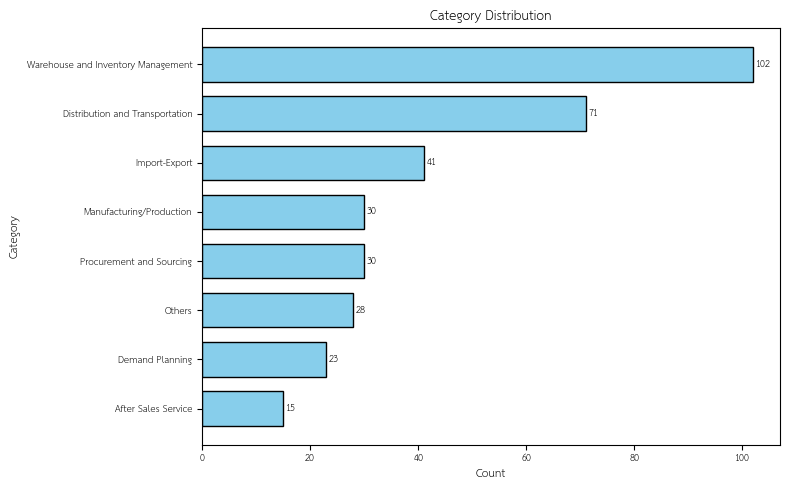

In [91]:
# Create a bar chart
topic_counts = df['category'].value_counts().sort_values(ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(topic_counts.index, topic_counts.values, color='skyblue', edgecolor='black', height=0.7)

# Add values to the bars, with dynamic positioning to avoid overlap
for bar in bars:
    bar_width = bar.get_width()
    bar_y = bar.get_y() + bar.get_height() / 2
    # Adjust the position of the labels to avoid overlap
    ax.text(bar_width + 0.5, bar_y, str(bar_width),
            va='center', ha='left', fontsize=10, color='black')

# Customize the chart
ax.set_title('Category Distribution', fontsize=14)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.set_xlim(0, max(topic_counts.values) + 5)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# plot save
plt.savefig('../images/category_distribution.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()

In [67]:
# Save cleaned dataframe to next process
df.to_csv('../data/cleaned_text.csv', index=False)

---

### Check Common word in each topic category

In [68]:
thai_stopwords_list = ' '.join(thai_stopwords()).split()

In [69]:
# Define a custom tokenizer function that only matches Thai alphabet characters
def clean_tokenizer(text):
    thai_english_text = re.sub(r'[^ก-๙ก-ฮa-zA-Z\s]', '', text)
    words_list = word_tokenize(thai_english_text, custom_dict=custom_trie, engine="newmm")
    words_list_cleaned = [word.strip() for word in words_list if word not in thai_stopwords_list]
    return words_list_cleaned

In [70]:
# Initialize the CountVectorizer with a custom token_pattern and stop words list
cvec = CountVectorizer(
    tokenizer=clean_tokenizer,  # Custom tokenizer
    token_pattern=None
)

# Fit and transform the text data
X = cvec.fit_transform(df['content']).todense()  # Fitting and transforming
df_X = pd.DataFrame(X, columns=cvec.get_feature_names_out())  # Create DataFrame with words as columns
df_X.head()

df_X_pc = pd.concat([df['category'], df_X.drop(columns= '')], axis = 1)
df_X_pc = df_X_pc.loc[:, ~df_X_pc.columns.duplicated()].groupby('category').sum()
df_X_pc.T.head()

category        After Sales Service  Demand Planning  \
a                                46               71   
aa                                0                0   
aaa                               0                0   
aaltonen                          0                0   
aaoptimization                    0                0   

category        Distribution and Transportation  Import-Export  \
a                                            72             16   
aa                                            4              0   
aaa                                           0              0   
aaltonen                                      0              0   
aaoptimization                                0              0   

category        Manufacturing/Production  Others  Procurement and Sourcing  \
a                                     18      58                        59   
aa                                     0       0                         0   
aaa                                    0       0                         0   
aaltonen                               0       0                         0   
aaoptimization                         0       0                         0   

category        Warehouse and Inventory Management  
a                                              198  
aa                                               9  
aaa                                             13  
aaltonen                                         1  
aaoptimization                                   1

In [71]:
# 20 Top Words
df_top_words = df_X_pc.sum().sort_values()[-20:]

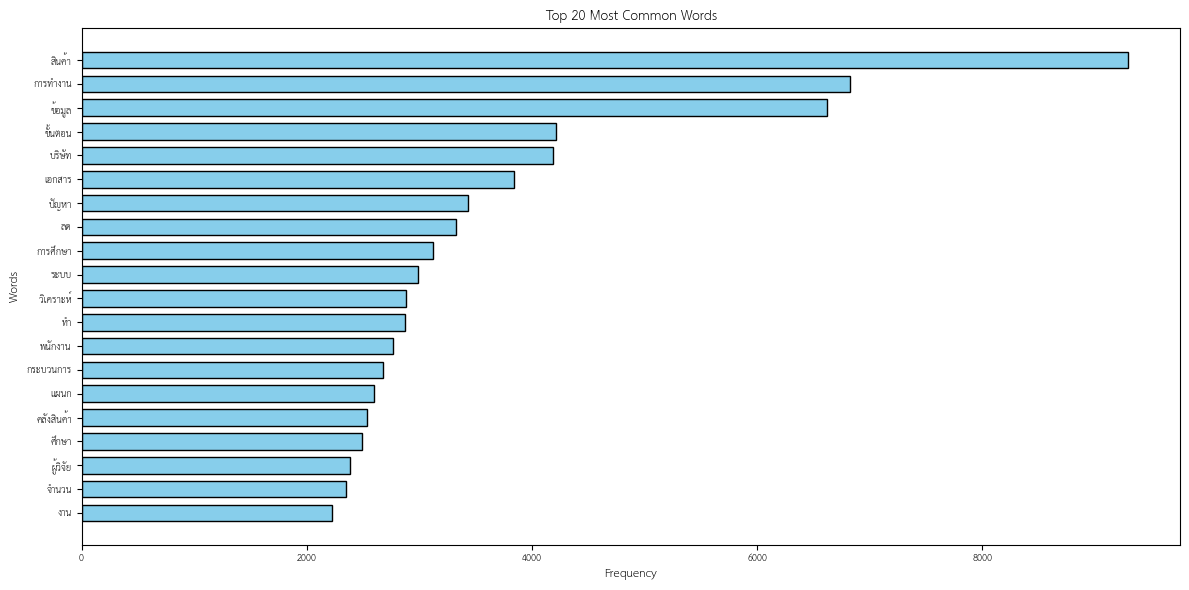

In [72]:
# Create a figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Generate the horizontal bar chart
bars = ax.barh(df_top_words.index, df_top_words.values, color='skyblue', edgecolor='black', height=0.7)

# Customize the chart
ax.set_title('Top 20 Most Common Words', fontsize=14)
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Words', fontsize=12)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# plot save
plt.savefig('../images/top20_words.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()

### WordCloud

In [73]:
avg_word_frequencies = df_X_pc.T.mean(axis=1)
df_with_avg = df_X_pc.T.copy()  # Copy the original DataFrame
df_with_avg['avg_word_frequencies'] = avg_word_frequencies


In [74]:
df_with_avg.iloc[:, 0:8] = df_with_avg.iloc[:, 0:8].sub(df_with_avg.iloc[:, 8], axis=0)
df_with_avg.drop(columns = 'avg_word_frequencies', inplace = True)
df_with_avg.head()

C:\Users\user\AppData\Local\Temp\ipykernel_16480\1065767264.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'a                -21.250
aa                -1.625
aaa               -1.625
aaltonen          -0.125
aaoptimization    -0.125
                   ...  
่                 -0.250
่ง                -0.250
้                 -0.500
์                  1.625
์ส                -0.125
Name: After Sales Service, Length: 17576, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_with_avg.iloc[:, 0:8] = df_with_avg.iloc[:, 0:8].sub(df_with_avg.iloc[:, 8], axis=0)
C:\Users\user\AppData\Local\Temp\ipykernel_16480\1065767264.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'a                 3.750
aa               -1.625
aaa              -1.625
aaltonen         -0.125
aaoptimization   -0.125
  

category        After Sales Service  Demand Planning  \
a                           -21.250            3.750   
aa                           -1.625           -1.625   
aaa                          -1.625           -1.625   
aaltonen                     -0.125           -0.125   
aaoptimization               -0.125           -0.125   

category        Distribution and Transportation  Import-Export  \
a                                         4.750        -51.250   
aa                                        2.375         -1.625   
aaa                                      -1.625         -1.625   
aaltonen                                 -0.125         -0.125   
aaoptimization                           -0.125         -0.125   

category        Manufacturing/Production  Others  Procurement and Sourcing  \
a                                -49.250  -9.250                    -8.250   
aa                                -1.625  -1.625                    -1.625   
aaa                               -1.625  -1.625                    -1.625   
aaltonen                          -0.125  -0.125                    -0.125   
aaoptimization                    -0.125  -0.125                    -0.125   

category        Warehouse and Inventory Management  
a                                          130.750  
aa                                           7.375  
aaa                                         11.375  
aaltonen                                     0.875  
aaoptimization                               0.875

In [75]:
df_with_avg.reset_index()

category           index  After Sales Service  Demand Planning  \
0                      a              -21.250            3.750   
1                     aa               -1.625           -1.625   
2                    aaa               -1.625           -1.625   
3               aaltonen               -0.125           -0.125   
4         aaoptimization               -0.125           -0.125   
...                  ...                  ...              ...   
17571                  ่               -0.250           -0.250   
17572                 ่ง               -0.250           -0.250   
17573                  ้               -0.500           -0.500   
17574                  ์                1.625           -0.375   
17575                 ์ส               -0.125           -0.125   

category  Distribution and Transportation  Import-Export  \
0                                   4.750        -51.250   
1                                   2.375         -1.625   
2                                  -1.625         -1.625   
3                                  -0.125         -0.125   
4                                  -0.125         -0.125   
...                                   ...            ...   
17571                              -0.250         -0.250   
17572                              -0.250         -0.250   
17573                               0.500         -0.500   
17574                              -1.375         -1.375   
17575                              -0.125         -0.125   

category  Manufacturing/Production  Others  Procurement and Sourcing  \
0                          -49.250  -9.250                    -8.250   
1                           -1.625  -1.625                    -1.625   
2                           -1.625  -1.625                    -1.625   
3                           -0.125  -0.125                    -0.125   
4                           -0.125  -0.125                    -0.125   
...                            ...     ...                       ...   
17571                       -0.250  -0.250                     0.750   
17572                       -0.250  -0.250                     1.750   
17573                        0.500  -0.500                     0.500   
17574                       -1.375  -0.375                    -0.375   
17575                       -0.125  -0.125                     0.875   

category  Warehouse and Inventory Management  
0                                    130.750  
1                                      7.375  
2                                     11.375  
3                                      0.875  
4                                      0.875  
...                                      ...  
17571                                  0.750  
17572                                 -0.250  
17573                                  0.500  
17574                                  3.625  
17575                                 -0.125  

[17576 rows x 9 columns]

In [77]:
for col in df_with_avg.columns:
 #   topic_counts = topic_counts.reset_index()
    value = topic_counts[topic_counts['category'] == col]['count'].values[0]
    df_with_avg_least = df_with_avg.copy()
    df_with_avg_least[col] = df_with_avg_least[col]/value


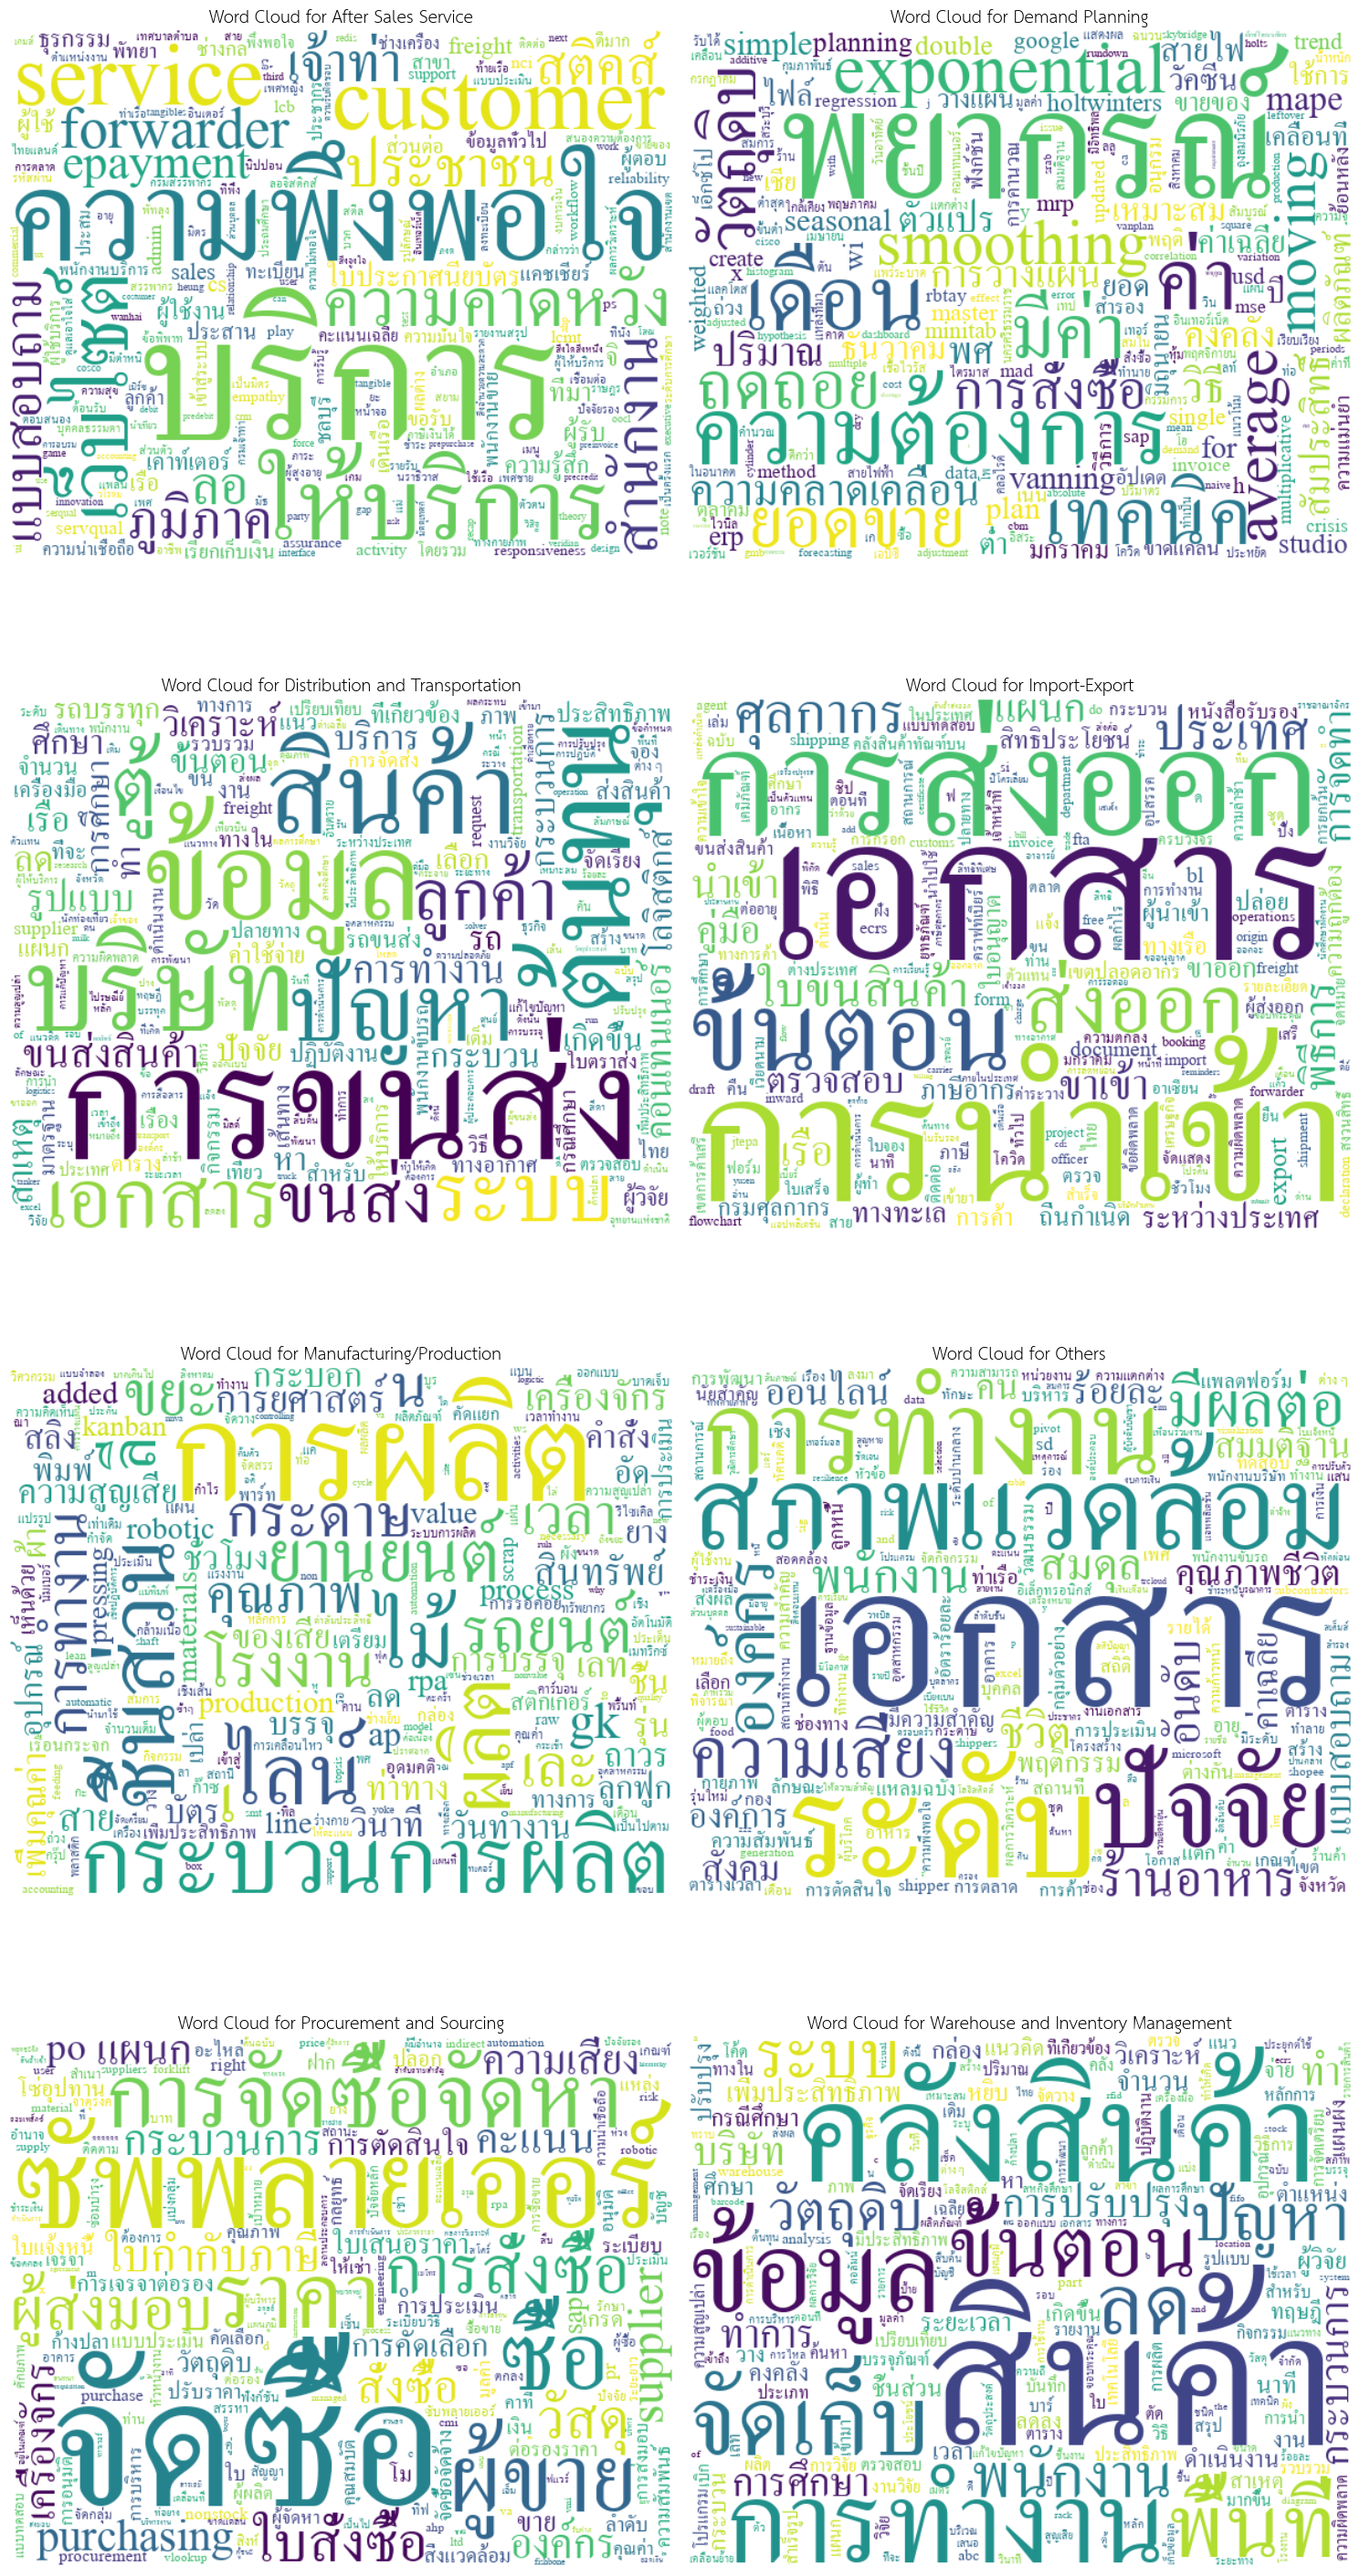

In [78]:
# Path to Thai font (change this path based on where you store the font on your machine)
thai_font_path = 'content/angsana.ttc'

# Create a figure with 4 rows and 2 columns for subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))

# Flatten the 2D axes array to make it easier to iterate
axes = axes.flatten()

# Iterate through the columns of df_with_avg and generate word clouds
for i, col in enumerate(df_with_avg.columns):
    cats = dict(zip(df_with_avg_least.index, df_with_avg_least[col]))
    
    # Generate WordCloud for Thai text
    wordcloud = WordCloud(width=600, 
                          height=480, 
                          background_color='white',
                          font_path=thai_font_path).generate_from_frequencies(cats)
    
    # Plot the word cloud in the corresponding subplot
    ax = axes[i]  # Get the flattened subplot corresponding to the column
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # Hide the axis
    ax.set_title(f'Word Cloud for {col}', fontsize=20)
    
plt.tight_layout()
plt.savefig('../images/cat_wordcloud.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()


In [79]:
df_with_avg_least['max_value'] = df_with_avg_least.max(axis=1)

df_with_avg_least['max_column'] = df_with_avg_least.idxmax(axis=1)

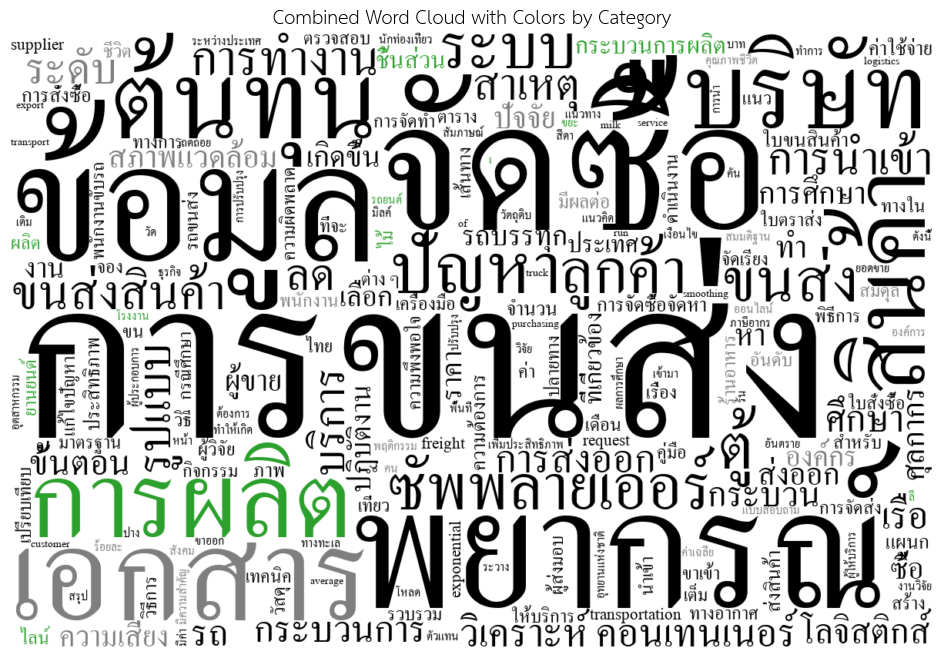

In [80]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Path to Thai font (adjust this to your setup)
thai_font_path = 'content/angsana.ttc'

# Define a color palette for each column
color_palette = {
    'Procurement': '#1f77b4',
    'Demand Planning and Forecasting': '#ff7f0e',
    'Manufacturing/Production': '#2ca02c',
    'Inventory Management': '#d62728',
    'Logistics and Distribution': '#9467bd',
    'Import-Export and International Trade': '#8c564b',
    'Customer Service': '#e377c2',
    'Others': '#7f7f7f',
}

# Prepare word frequencies and colors
combined_frequencies = dict(zip(df_with_avg_least.index, df_with_avg_least['max_value']))
word_colors = dict(zip(df_with_avg_least.index, df_with_avg_least['max_column']))

# Function to assign color based on the max_column
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    category = word_colors.get(word, None)  # Get the category name
    return color_palette.get(category, '#000000')  # Default to black if no match

# Generate the word cloud
wordcloud = WordCloud(width=1200,
                      height=800,
                      background_color='white',
                      font_path=thai_font_path).generate_from_frequencies(combined_frequencies)

# Apply the custom color function
wordcloud.recolor(color_func=color_func)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Combined Word Cloud with Colors by Category', fontsize=20)

# Save the plot (optional)
plt.savefig('../images/wordcloud.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [81]:
top_each_cat = []
for col in df_with_avg.columns:
    top = df_with_avg.sort_values(by = col, ascending =False).head(1)
    top_each_cat +=list(top.index)

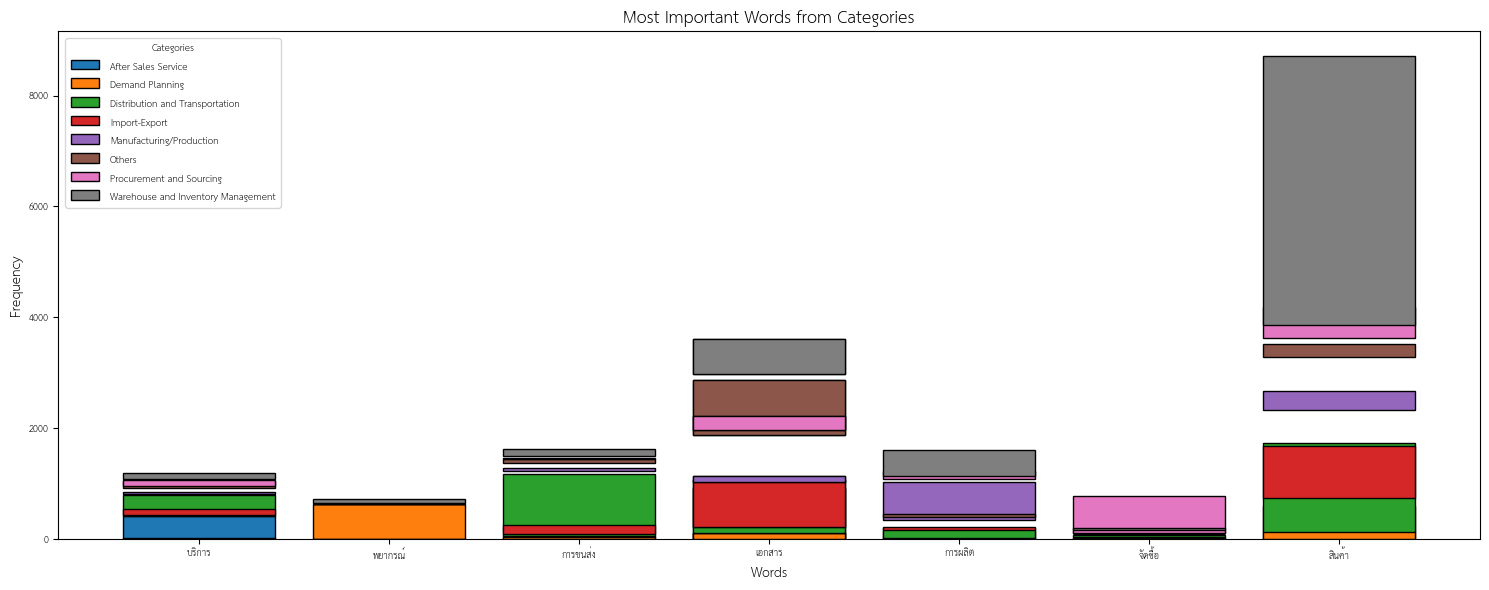

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_X_pc and top_each_cat are defined, and df_stacked is created correctly
df_stacked = pd.DataFrame(df_X_pc.T, index=top_each_cat)

# Create a figure and axis for the stacked bar chart
fig, ax = plt.subplots(figsize=(15, 6))

# Generate the stacked bar chart
categories = df_stacked.columns
index = df_stacked.index

# Stack the bars by iterating through each category
ax.bar(index, df_stacked[categories[0]], label=categories[0], edgecolor='black')  # Start with the first category

# Loop through remaining categories and stack on top of previous bars
for i, category in enumerate(categories[1:]):
    ax.bar(index, df_stacked[category], bottom=df_stacked[categories[:i]].sum(axis=1), label=category, edgecolor='black')

# Customize the chart
ax.set_title('Most Important Words from Categories', fontsize=18)
ax.set_xlabel('Words', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.legend(title='Categories')  # Add legend

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('../images/words_importance_stacked.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
